# Train ML Model
I am going to have an explore and see what is best though, as usual, I expect XGBoost will be all conquering for this discussion because again we are working with tabular data. I will read it in using Polars this time for performance reasons.

In [111]:
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
import mplhep as hep
hep.style.use(hep.style.ROOT)

In [6]:
column_names = [
    "straw1x", "straw1y", "trim5x", "trim5y", "tktag", "tgtk", "trich",
    "mm2rich", "mm2nom", "mm2", "p", "prich", "vtxz", "vtxx", "vtxy",
    "thetax", "thetay", "rstraw1", "nktaghits", "ngtkhits" 
]

## Defining Features
For the time being I will use the exact same set of features and the same training sets as the ROOT TMVA that is currently implemented. Then we can evaluate the performance differences if any and start tuning from this baseline.

In [14]:
features = [
    "straw1x", "straw1y", "trim5x", "trim5y", "rstraw1", "vtxz", "vtxx", "vtxy", "thetax", "thetay"
]

In [13]:
signal = pl.read_csv("data/BDT_Train_KpinnNoovCombined_07_05_2024.txt", has_header=False)
signal = signal.drop("column_21")
signal.columns = column_names
signal.head()

straw1x,straw1y,trim5x,trim5y,tktag,tgtk,trich,mm2rich,mm2nom,mm2,p,prich,vtxz,vtxx,vtxy,thetax,thetay,rstraw1,nktaghits,ngtkhits
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
312.095,-131.105,-345.227,204.3,18.3799,18.1938,18.2787,-0.002707,0.003251,0.002403,25.1484,26.0095,153.006,66.5434,-6.06644,0.008046,-0.004102,248.325,19,1
634.572,-176.502,-56.6356,7.3429,2.08454,2.17705,2.00025,0.0518736,0.0456794,0.0504472,18.0189,17.3942,107.088,-11.888,-4.342,0.0084494,-0.002254,561.818,20,1
-83.6746,-207.629,69.7437,123.733,2.69263,2.86549,2.63019,0.058194,0.0505023,0.0501381,32.2208,30.0798,132.043,12.9672,0.940185,-0.001878,-0.004056,278.008,24,1
278.088,25.8314,-126.514,-25.6616,8.32454,8.32077,8.39304,0.0666234,0.0460587,0.0493646,42.081,36.9081,134.166,33.7764,-5.73591,0.004952,0.00063,178.764,18,1
182.272,-94.061,-422.501,472.514,21.8005,21.5653,21.5731,0.002001,-0.001506,0.004035,19.4689,19.8229,169.853,80.9583,0.434846,0.007406,-0.006932,124.178,14,1


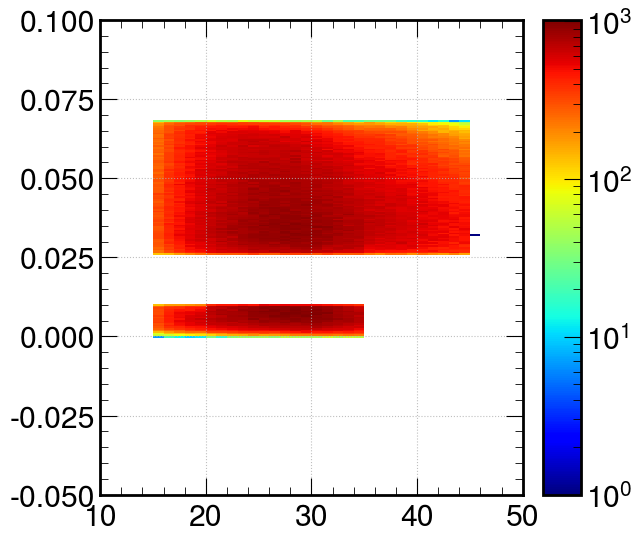

In [21]:
plt.figure(figsize=(7, 6))
h, xbins, ybins = np.histogram2d(signal["p"].to_numpy(), signal["mm2"].to_numpy(), bins=(np.linspace(10, 50, 41), np.linspace(-0.05, 0.1, 300)))
hep.hist2dplot(h, xbins, ybins, cmap="jet", norm=LogNorm())
plt.grid()
plt.tight_layout()
plt.show()

In [22]:
bkg = pl.read_csv("data/BDT_Training_2022_Upstream_v1.txt", has_header=False)
bkg = bkg.drop("column_21")
bkg.columns = column_names
bkg.head()

straw1x,straw1y,trim5x,trim5y,tktag,tgtk,trich,mm2rich,mm2nom,mm2,p,prich,vtxz,vtxx,vtxy,thetax,thetay,rstraw1,nktaghits,ngtkhits
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
-68.0299,279.747,28.6767,14.943,1.2994,1.13159,1.865,0.0500274,0.0570516,0.0502806,37.4221,37.5074,105.508,5.70961,12.5621,-0.001189,0.003239,326.951,13,2
409.753,-27.8752,3.97157,-24.3514,23.8973,23.3642,23.8509,0.0350101,0.0548933,0.0519517,39.9516,44.6745,107.585,33.1368,-12.12,0.004962,-0.000045,309.809,26,2
280.481,353.405,-4.48336,-25.1719,19.5295,17.952,19.5304,0.0437153,0.0263379,0.0283762,37.8837,34.02,108.88,17.3879,9.05221,0.003483,0.004631,396.279,18,1
61.8522,263.635,-4.56718,-18.8885,14.1939,13.3697,12.4157,0.0801009,0.0859256,0.0872918,31.5518,34.2061,110.313,-3.9887,9.76446,0.000808,0.003455,266.556,26,4
238.631,153.092,-37.2293,-4.44433,6.96362,8.95373,6.77096,0.105333,0.10691,0.105837,25.6693,25.8945,116.525,19.8187,14.3305,0.003373,0.001924,205.729,6,1


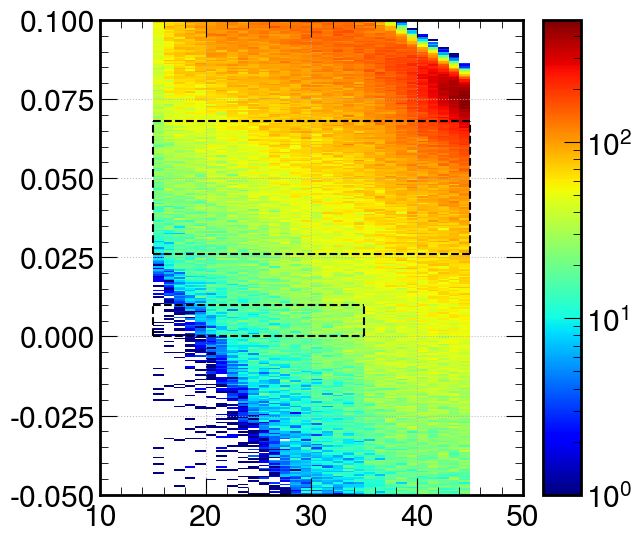

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
h, xbins, ybins = np.histogram2d(bkg["p"].to_numpy(), bkg["mm2"].to_numpy(), bins=(np.linspace(10, 50, 41), np.linspace(-0.05, 0.1, 300)))
hep.hist2dplot(h, xbins, ybins, cmap="jet", norm=LogNorm())
ax.vlines([15, 35], 0.0, 0.01, color="k", linestyles="--")
ax.vlines([15, 45], 0.026, 0.068, color="k", linestyles="--")
ax.hlines([0.0, 0.01], 15, 35, color="k", linestyles="--")
ax.hlines([0.026, 0.068], 15, 45, color="k", linestyles="--")
plt.grid()
plt.tight_layout()
plt.show()

Constrain the background sample to the signal region (should actually be done on the analyser level, this was an oversight).

In [42]:
bkg = bkg.filter(
    ((pl.col("mm2").is_between(0.0, 0.01)) & (pl.col("p").is_between(15.0, 35.0))) |
    (pl.col("mm2").is_between(0.026, 0.068))
)

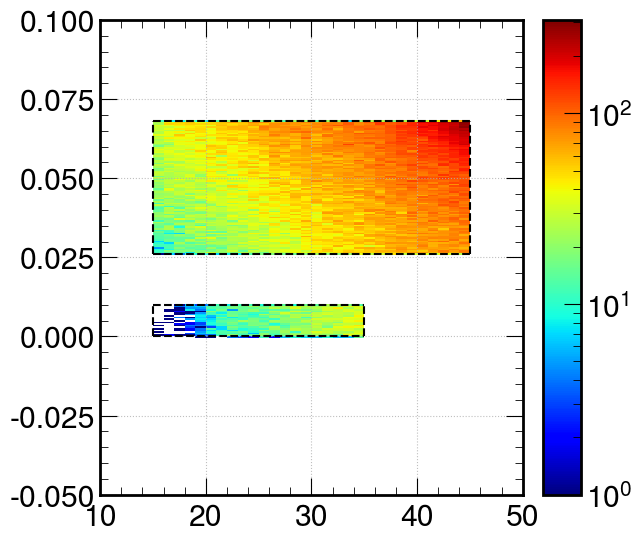

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
h, xbins, ybins = np.histogram2d(bkg["p"].to_numpy(), bkg["mm2"].to_numpy(), bins=(np.linspace(10, 50, 41), np.linspace(-0.05, 0.1, 300)))
hep.hist2dplot(h, xbins, ybins, cmap="jet", norm=LogNorm())
ax.vlines([15, 35], 0.0, 0.01, color="k", linestyles="--")
ax.vlines([15, 45], 0.026, 0.068, color="k", linestyles="--")
ax.hlines([0.0, 0.01], 15, 35, color="k", linestyles="--")
ax.hlines([0.026, 0.068], 15, 45, color="k", linestyles="--")
plt.grid()
plt.tight_layout()
plt.show()

## Making Training Samples

In [46]:
# Add target indicators
signal = signal.with_columns(pl.lit(1).alias('isSignal'))
bkg = bkg.with_columns(pl.lit(0).alias('isSignal'))

In [79]:
# Combine the dataframes together
df = pl.concat([signal, bkg], how='vertical')
X_train, X_test, y_train, y_test = train_test_split(df.drop("isSignal"), df["isSignal"], test_size=0.1, random_state=42)

## Training a Classifier

In [80]:
model = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
)

# TODO: Adjust the hyperparameters, weight the classes, adjust decision boundary, add/take away features

model.fit(X_train[features].to_numpy().astype(np.float64), y_train.to_numpy().astype(np.float64))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Evaluate Training

In [82]:
predictions = model.predict(X_test[features].to_numpy().astype(np.float64))
f1 = f1_score(y_test.to_numpy().astype(np.float64), predictions)
print("F1 Score: ", f1)

F1 Score:  0.9871333423541262


In [84]:
signalLikelihood = model.predict_proba(X_test[features].to_numpy().astype(np.float64))[:,0] # Probabiltiy that it is signal

In [85]:
# Plot the F1 score as a function of the decision boundary
def get_pred(cut):
    return (signalLikelihood > cut).astype(np.int64)

f1_scores = [f1_score(y_test.to_numpy().astype(np.float64), get_pred(cut)) for cut in np.linspace(0, 1, 100)]

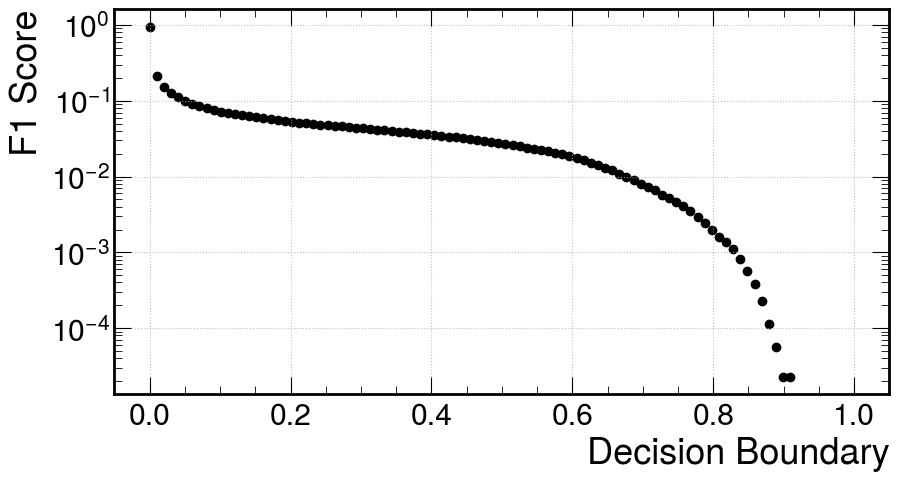

In [86]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel("F1 Score")
plt.xlabel("Decision Boundary")
plt.scatter(np.linspace(0, 1, 100), f1_scores, color="black")
plt.yscale('log')
plt.grid()
plt.show()

Let's have a look at the impact on the missing mass spectrum at a decision boundary of 0.2 for the test events which are background-like.

In [89]:
# Add truth labels to X_test
X_test = X_test.with_columns(pl.lit(y_test).alias('isSignal'))

In [93]:
test_pred = model.predict_proba(X_test[features].to_numpy().astype(np.float64))[:,0]
X_test = X_test.with_columns(pl.Series("pred", test_pred))

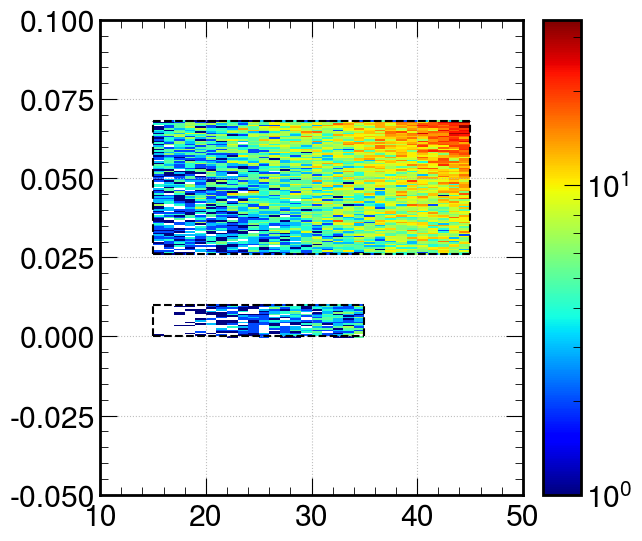

In [91]:
# All the background events in the test set
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
h, xbins, ybins = np.histogram2d(X_test.filter(pl.col('isSignal').eq(0))["p"].to_numpy(), X_test.filter(pl.col('isSignal').eq(0))["mm2"].to_numpy(), bins=(np.linspace(10, 50, 41), np.linspace(-0.05, 0.1, 300)))
hep.hist2dplot(h, xbins, ybins, cmap="jet", norm=LogNorm())
ax.vlines([15, 35], 0.0, 0.01, color="k", linestyles="--")
ax.vlines([15, 45], 0.026, 0.068, color="k", linestyles="--")
ax.hlines([0.0, 0.01], 15, 35, color="k", linestyles="--")
ax.hlines([0.026, 0.068], 15, 45, color="k", linestyles="--")
plt.grid()
plt.tight_layout()
plt.show()

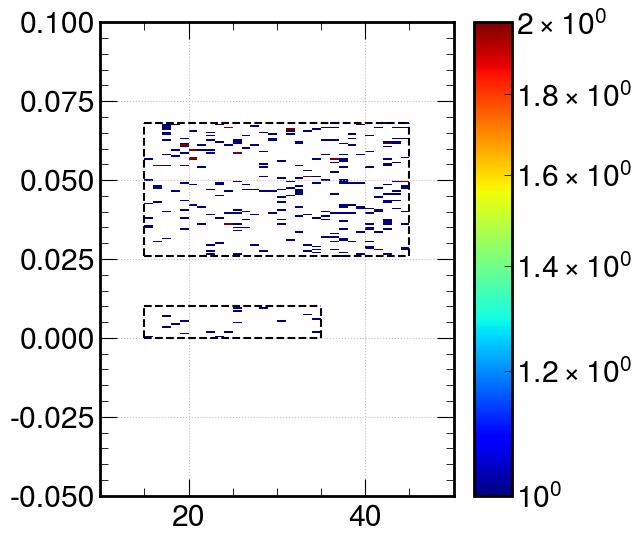

In [105]:
# All the background events in the test set
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
h, xbins, ybins = np.histogram2d(
    X_test.filter(
        (pl.col('isSignal').eq(0)) & (pl.col('pred').lt(0.1))
    )["p"].to_numpy(), 
    X_test.filter(
        (pl.col('isSignal').eq(0)) & (pl.col('pred').lt(0.1))
    )["mm2"].to_numpy(), 
    bins=(np.linspace(10, 50, 41), np.linspace(-0.05, 0.1, 300))
)
hep.hist2dplot(h, xbins, ybins, cmap="jet", norm=LogNorm())
ax.vlines([15, 35], 0.0, 0.01, color="k", linestyles="--")
ax.vlines([15, 45], 0.026, 0.068, color="k", linestyles="--")
ax.hlines([0.0, 0.01], 15, 35, color="k", linestyles="--")
ax.hlines([0.026, 0.068], 15, 45, color="k", linestyles="--")
plt.grid()
plt.tight_layout()
plt.show()

# A reduction across the entire phase space, let us now see the difference this cut makes on the signal

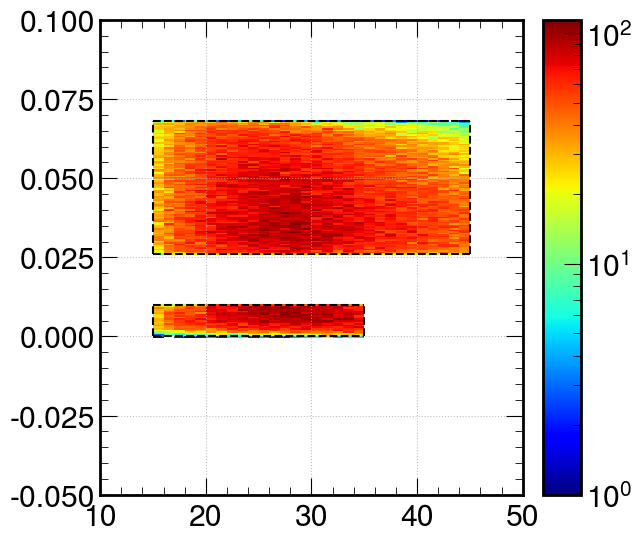

In [103]:
# All the background events in the test set
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
h, xbins, ybins = np.histogram2d(
    X_test.filter(
        (pl.col('isSignal').eq(1))
    )["p"].to_numpy(), 
    X_test.filter(
        (pl.col('isSignal').eq(1))
    )["mm2"].to_numpy(), 
    bins=(np.linspace(10, 50, 41), np.linspace(-0.05, 0.1, 300))
)
hep.hist2dplot(h, xbins, ybins, cmap="jet", norm=LogNorm())
ax.vlines([15, 35], 0.0, 0.01, color="k", linestyles="--")
ax.vlines([15, 45], 0.026, 0.068, color="k", linestyles="--")
ax.hlines([0.0, 0.01], 15, 35, color="k", linestyles="--")
ax.hlines([0.026, 0.068], 15, 45, color="k", linestyles="--")
plt.grid()
plt.tight_layout()
plt.show()

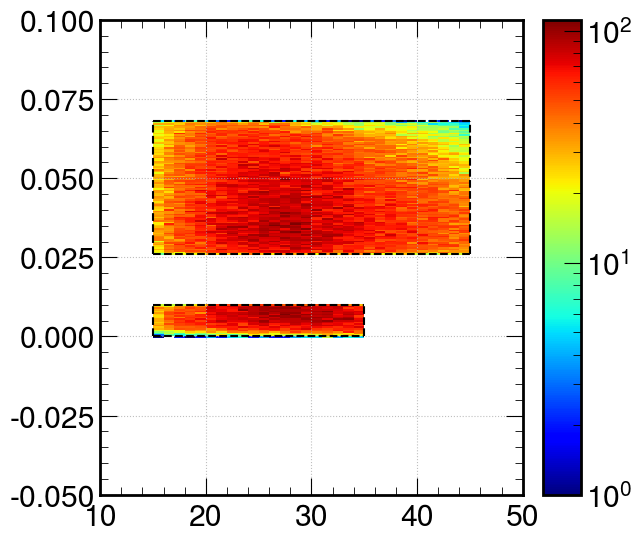

In [106]:
# All the background events in the test set
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
h, xbins, ybins = np.histogram2d(
    X_test.filter(
        (pl.col('isSignal').eq(1)) & (pl.col('pred').lt(0.1))
    )["p"].to_numpy(), 
    X_test.filter(
        (pl.col('isSignal').eq(1)) & (pl.col('pred').lt(0.1))
    )["mm2"].to_numpy(), 
    bins=(np.linspace(10, 50, 41), np.linspace(-0.05, 0.1, 300))
)
hep.hist2dplot(h, xbins, ybins, cmap="jet", norm=LogNorm())
ax.vlines([15, 35], 0.0, 0.01, color="k", linestyles="--")
ax.vlines([15, 45], 0.026, 0.068, color="k", linestyles="--")
ax.hlines([0.0, 0.01], 15, 35, color="k", linestyles="--")
ax.hlines([0.026, 0.068], 15, 45, color="k", linestyles="--")
plt.grid()
plt.tight_layout()
plt.show()

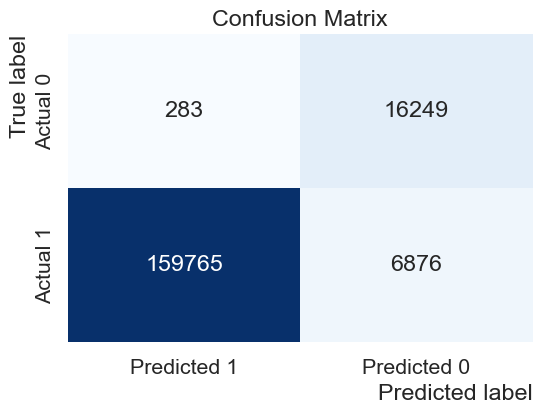

In [115]:
# Now lets get the raw counts via a confusion matrix and a custom deicision boundary
conf_matrix = confusion_matrix(y_test.to_numpy().astype(np.float64), get_pred(0.1))
sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted 1', 'Predicted 0'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()